
<!---- deploy info ---->

# ニューラルネットワークの基礎

------------
## このテキストについて

### テキストの目的

- ニューラルネットワークの基礎を知る
- 順伝播法を理解する
- 逆伝播法を理解する

### どのように学ぶか

基本である重回帰や一般化線形モデルを意識しながら完全に新しい手法として覚えるのではなく、今までの知識で記述できることを感じましょう。

------------

## ニューラルネットワークとは

一般にNeural Network(以下NN)はGeneralized Linear Model(以下GLM)の文脈で学ばれます。GLMの多出力・多層モデルがNNと同値関係あるからです。

一般化線形モデルを思い出してみましょう。

### 一般化線形モデル

行列を以下のような形で定義します。

$$
\hat{y} = 
  \begin{bmatrix}
    \hat{y_1} \\
    \hat{y_2} \\
    \vdots \\
    \hat{y_n}
  \end{bmatrix},
W = 
  \begin{bmatrix}
    w_0 \\
    w_1 \\
    w_2 \\
    \vdots \\
    w_d
  \end{bmatrix},
X = 
  \begin{bmatrix}
    x_{01} & x_{11} & \cdots & x_{d1} \\
    x_{02} & x_{12} & \cdots & x_{d2} \\
    \vdots & \vdots & \ddots & \vdots \\
    x_{0n} & x_{1n} & \cdots & x_{dn}
  \end{bmatrix} \\
$$

一般化線形モデルの枠組みでは、線形予測子 $\eta = XW$ をさらに関数に入れることで、誤差の分布を解析対象に沿うようなものにするものでした。対数尤度などを駆使して微分することで、最適なパラメータを求めていました。

### ニューラルネットワークと線形代数

GLMの多出力・多層モデルがNNと同値関係あるといいました。
これは、ニューラルネットワーク各層は全てGLMの多出力モデルと解釈できるためです。

今回は行列を以下のように定義します。

$$
X =
  \begin{bmatrix}
    X_{11} & X_{12} & \cdots & w_{1d} \\
    X_{21} & w_{22} & \cdots & w_{2d} \\
    \vdots & \vdots & \ddots & \vdots \\
    X_{n1} & X_{n2} & \cdots & w_{nd}
  \end{bmatrix},
W =
  \begin{bmatrix}
    w_{11} & w_{12} & \cdots & w_{1h} \\
    w_{21} & w_{22} & \cdots & w_{2h} \\
    \vdots & \vdots & \ddots & \vdots \\
    w_{d1} & w_{d2} & \cdots & w_{dh}
  \end{bmatrix},
b =
  \begin{bmatrix}
    b_{1} \\
    b_{2} \\
    \vdots \\
    b_{h}
  \end{bmatrix}
$$

$$
\hat{y} = XW + b
$$

$$
X \in \mathbb{R}^{(n \times d)},
W \in \mathbb{R}^{(d \times h)},
b \in \mathbb{R}^{(h)},
\hat{y} \in \mathbb{R}^{(n \times h)}
$$

$n$ : バッチサイズ

$d$ : 入力される特徴量の数

$h$ : 出力する特徴量の数

$d$ 次元空間にある $n$ 個のデータを $h$ 次元空間に写像するというイメージです。
線形回帰のイメージでは、求めたい目的変数が $h$ 個あるような状況で、それを同時に作るようなものです。

バイアス項は次元が合っていませんが、バッチ方向に同じ値を作って $b \in \mathbb{R}^{(n \times h)}$ と考えてください。実装時はブロードキャストでこれを実現してください。

*補足*
>線形写像というものがあります。簡単な例を出すと $f(x,y,z)=ax + by + cz$ のような関数は線形写像になります。この時、この関数 $f$ は ３次元ベクトル $(x,y,z)$ から、係数をかけて線形結合することでスカラー値にしています。\
関数がどのような写像をするのかわかりやすくするため $f : \mathbb{R}^3 \rightarrow \mathbb{R}^1$ と書くことが多いです。\
見慣れないかもしれませんが、仮に $f(x,y,z)=(ax + by + cz,dx + ey + fz)$となる写像があるならこれは $f : \mathbb{R}^3 \rightarrow \mathbb{R}^2$ と書けます。\
この係数を取り出して、並べたものを行列として行列演算を定義しています。\
今回の例では、
$$
A =
  \begin{bmatrix}
    a & b & c \\
    d & e & f
  \end{bmatrix},
X = 
  \begin{bmatrix}
    x \\
    y \\
    z
  \end{bmatrix},\\
AX =
  \begin{bmatrix}
    ax + by + cz \\
    dx + ey + fz
  \end{bmatrix}
$$
となります。\
一般で考える場合、任意の自然数 $m,n$ において実数値行列$(m,n)$ は線形写像 $f:\mathbb{R}^m \rightarrow \mathbb{R}^n$ を実現します。複素数行列の場合には $f:\mathbb{C}^m \rightarrow \mathbb{C}^n$ となります。
余裕があればそういった観点も踏まえて、行列を考えてみましょう。

まず、活性化関数がない（もしくは恒等関数とみなす）隠れ層が１層のNNを考えます。
これは隠れ層の意味がなくなってしまいますが、学習上とても有用なので追っていきます。

まずはモデルが小さくても済むようにIrisを分類するモデルを考えることにしましょう。設定としては、まずは簡単にバッチサイズ１で中間層は５つのノードを持っているNNを考えることにします。出力層には多値分類のためソフトマックス関数を使います。

ソフトマックス関数とは $n$ 次元ベクトル $x$ のk番目の値を
$$
y_k = softmax(x_k) = \frac{exp(x_k)}{\sum^{n}_{i=1} exp(x_i)}
$$
このように正規化して確率解釈するための関数です。
イメージとしてはシグモイド関数の多値バージョンです。

Irisは特徴量が４で、ラベルは３種類なので、入力層のノード数と出力層のノード数はそれぞれ４、３になります。

このような図になるNNですね。
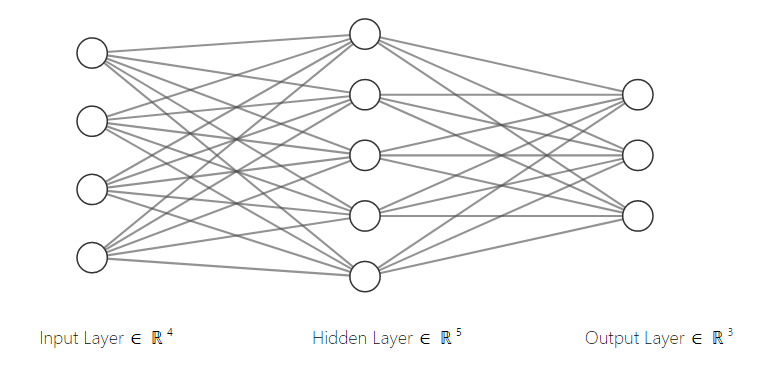

この時それぞれの行列の形は

入力$X(1,4)$

$W_1(4,5),B_1(1,5)$

$W_2(5,3),B_2(1,3)$

となります。
仮にバッチサイズが１ではなくても、計算が定義できることを確認してください。

## 順伝播

順伝播は簡単です。

入力層 $\rightarrow$ 中間層
$$
A_1 = XW_1 + B_1\\
Z_1 = f_1(A_1) = A_1W_1 + B_1
$$

中間層 $\rightarrow$ 出力層
$$
A_2 = XW_2 + B_2\\
y = f_2(A_2) = softmax(A_2)
$$

このように入力からの値を前に伝えていきます。

## 逆伝播

逆伝播では出力層から考えていきます。
出力層の先にはラベルがあります。
今回はIrisデータセットを例にしているので、
$$
t = \begin{bmatrix}1 & 0 & 0\end{bmatrix}
$$
等がラベルになります。

交差エントロピー誤差 $E$ を求めます。

$$
E = - \sum_{i=1}^{1} \sum_{c=1}^3 t_c^{(i)} \log{y_c^{(i)}}
$$

外側の $i$ についてのシグマはバッチに対応しています。今回はバッチサイズを１として考えているので、必要ありませんが、一般化のため書いています。

これまでと同じようにこれを最小にするようにパラメータを最適させていきます。

最適化させたいパラメータは $W_1, B_1, W_2, B_2$ の四つです。

後ろの層から求めていきましょう。

偏微分における連鎖律という概念を利用して以下のように式変形できます。微分演算は分数のように扱えることが知られていますので、以下の変形は問題ありません。

$$
\frac{\partial E}{\partial W_2} = \frac{\partial E}{\partial y} \frac{\partial y}{\partial W_2}
$$

右辺のそれぞれの導出を追ってみましょう。

$$
\frac{\partial E}{\partial y} = - \frac{\partial}{\partial y} \sum_{i=1}^{1} \sum_{c=1}^3 t_c^{(i)} \log{y_c^{(i)}}
$$


